In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", category=UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1

In [115]:
train=pd.read_csv('train.csv',sep='|')
test=pd.read_csv('test.csv',sep='|')

In [108]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

In [116]:
# for training set

train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']


# for test set

test['scannedLineItems'] = test['scannedLineItemsPerSecond'] * test['totalScanTimeInSeconds']
test['pricePerScannedLineItem'] = test['grandTotal'] / test['scannedLineItems']
test['scansWithoutRegistrationPerScannedLineItem'] = test['scansWithoutRegistration'] / test['scannedLineItems']
test['quantityModificationsPerScannedLineItem'] = test['quantityModifications'] / test['scannedLineItems']
test['lineItemVoidsPerSecond'] = test['lineItemVoids'] / test['totalScanTimeInSeconds']
test['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
test['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
test['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
test['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
test['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
test['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

# Applying oversampling to dataset
- Classical Oversampling
- SMOTE Technique
- ADASYN Technique

Each one has a slightly different approach for generating synthetic instances
- Simply duplicated fraud instances
- ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier
- SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule.


The next three cells only define the functions, actually appliing oversampling for subsequent steps can be down after the definitions


Old comment of Jan:

Only run one of the following three cells to apply a specific oversampling method!
Attention!! If we use oversampling we have problems using k-fold cross validation. Since we have a faked test set. It would be better to oversample in every k-fold iteration. ALternatively we need to switch back to a fixed training, test split.  
This is not implemented yet!

In [120]:
# !pip install imblearn  # might be necessary for installation
from imblearn.over_sampling import RandomOverSampler

def randomOverSampling(train):
    ros = RandomOverSampler(random_state=42)
    X_train_extended, Y_train_extended = ros.fit_resample(train.drop('fraud',axis=1), train['fraud'])

    new_train = pd.DataFrame(X_train_extended, columns=train.drop('fraud',axis=1).columns) 
    new_train["fraud"] = Y_train_extended
    return new_train
    
randomOverSampling(train)

print(randomOverSampling(train).fraud.value_counts())
print(randomOverSampling(train).fraud.value_counts() / len(smoteOverSamling(train)))

1    1775
0    1775
Name: fraud, dtype: int64
1    0.5
0    0.5
Name: fraud, dtype: float64


In [127]:
from imblearn.over_sampling import SMOTE

def smoteOverSamling(train):
    sm = SMOTE(random_state=42)
    X_train_extended, Y_train_extended = sm.fit_sample(X_train, y_train)

    new_train = pd.DataFrame(X_train_extended, columns=train.drop('fraud',axis=1).columns) 
    new_train ["fraud"] = Y_train_extended
    return new_train
    
print(smoteOverSamling(train).fraud.value_counts())
print(smoteOverSamling(train).fraud.value_counts() / len(smoteOverSamling(train)))

1    1775
0    1775
Name: fraud, dtype: int64
1    0.5
0    0.5
Name: fraud, dtype: float64


In [128]:
from imblearn.over_sampling import ADASYN

def adasynOverSamling(train):
    ada = ADASYN(random_state=42)
    X_train_extended, Y_train_extended = ada.fit_resample(X_train, y_train)

    new_train = pd.DataFrame(X_train_extended, columns=train.drop('fraud',axis=1).columns) 
    new_train["fraud"] = Y_train_extended
    return new_train
    
print(adasynOverSamling(train).fraud.value_counts())
print(adasynOverSamling(train).fraud.value_counts() / len(train))

1    1790
0    1775
Name: fraud, dtype: int64
1    0.952634
0    0.944651
Name: fraud, dtype: float64


# Actually apply one of these techniques

In [ ]:
# train = smoteOverSamling(train)

# Building model factory

In [164]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm.classes import OneClassSVM
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.neighbors.classification import RadiusNeighborsClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model.ridge import RidgeClassifierCV
from sklearn.linear_model.ridge import RidgeClassifier
from sklearn.linear_model.passive_aggressive import PassiveAggressiveClassifier
from sklearn.gaussian_process.gpc import GaussianProcessClassifier
from sklearn.ensemble.voting_classifier import VotingClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
# from sklearn.mixture import DPGMM
#from sklearn.mixture import GMM
#from sklearn.mixture import GaussianMixture
#from sklearn.mixture import VBGMM

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



model_tuning_factory = [
    GridSearchCV(LogisticRegression(max_iter = 10000), 
             dict(# penalty = ['l1','l2'],  # automatic regularization  -> option 'l1' doesnt work with all solvers and leads to errors
                 solver = ['newton-cg', 'lbfgs', 'liblinear'], 
                 fit_intercept = [True, False]),
                #  solver = ['lbfgs', 'liblinear', 'sag', 'saga']),
             cv = skf,
             scoring = my_custom_score),
    GridSearchCV(KNeighborsClassifier(), 
                 dict(n_neighbors = range(1,4),
                      weights = ['uniform', 'distance']),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(NearestCentroid(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(DecisionTreeClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # max_depth = range(1,100)),
                 #     max_leaf_nodes = range(2,100)),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(ExtraTreeClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # max_depth = range(1,100)),
                 #     max_leaf_nodes = range(2,100)),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(ExtraTreesClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                      # n_estimators  = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score),    
    GridSearchCV(RandomForestClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # n_estimators  = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score),    
    GridSearchCV(BernoulliNB(),
                 dict(binarize  = np.arange(0.0, 2.0, 0.1)),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(GaussianNB(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(AdaBoostClassifier(),
                 dict(),
                 #dict(n_estimators = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(GradientBoostingClassifier(),
                 dict(),
                 #dict(n_estimators = range(1,150)),
                 #     learning_rate = np.arange(0.01, 1.0, 0.01)),
                 cv = skf,
                 scoring = my_custom_score),                     
    GridSearchCV(BaggingClassifier(), 
                 dict(),
                 #dict(n_estimators = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(Perceptron(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(LinearDiscriminantAnalysis(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(QuadraticDiscriminantAnalysis(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(SVC(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score)
]       



model_tuning_factory_subset = [
    GridSearchCV(LogisticRegression(max_iter = 10000), 
                 dict(# penalty = ['l1','l2'],  # automatic regularization  -> option 'l1' doesnt work with all solvers and leads to errors
                     solver = ['newton-cg', 'lbfgs', 'liblinear'], 
                     fit_intercept = [True, False]),
                    #  solver = ['lbfgs', 'liblinear', 'sag', 'saga']),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(DecisionTreeClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # max_depth = range(1,100)),
                 #     max_leaf_nodes = range(2,100)),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(ExtraTreeClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # max_depth = range(1,100)),
                 #     max_leaf_nodes = range(2,100)),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(ExtraTreesClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                      # n_estimators  = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score),    
    GridSearchCV(RandomForestClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # n_estimators  = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score),    
    GridSearchCV(BernoulliNB(),
                 dict(binarize  = np.arange(0.0, 2.0, 0.1)),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(AdaBoostClassifier(),
                 dict(),
                 #dict(n_estimators = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(GradientBoostingClassifier(),
                 dict(),
                 #dict(n_estimators = range(1,150)),
                 #     learning_rate = np.arange(0.01, 1.0, 0.01)),
                 cv = skf,
                 scoring = my_custom_score),                     
    GridSearchCV(Perceptron(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(LinearDiscriminantAnalysis(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score)
]        
                 
                 
iterations = 10                 
               
model_tuning_factory_randomized = [
    RandomizedSearchCV(LogisticRegression(max_iter = 10000), 
                 dict(# penalty = ['l1','l2'],  # automatic regularization  -> option 'l1' doesnt work with all solvers and leads to errors
                       solver = ['newton-cg', 'lbfgs', 'liblinear'],
                       fit_intercept = [True, False]),
                    #  solver = ['lbfgs', 'liblinear', 'sag', 'saga']),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(KNeighborsClassifier(), 
                 dict(n_neighbors = range(1,4),
                      weights = ['uniform', 'distance']),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(NearestCentroid(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    RandomizedSearchCV(DecisionTreeClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # max_depth = range(1,100)),
                 #     max_leaf_nodes = range(2,100)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(ExtraTreeClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # max_depth = range(1,100)),
                 #     max_leaf_nodes = range(2,100)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(ExtraTreesClassifier(),
                 dict(criterion = ['entropy', 'gini'],
                      n_estimators  = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score),    
    RandomizedSearchCV(RandomForestClassifier(),
                 dict(criterion = ['entropy', 'gini'],
                      n_estimators  = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),    
    RandomizedSearchCV(BernoulliNB(),
                 dict(binarize  = np.arange(0.0, 1.0, 0.1)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations), 
    RandomizedSearchCV(GaussianNB(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    RandomizedSearchCV(AdaBoostClassifier(),
                 dict(n_estimators = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(GradientBoostingClassifier(),
                 dict(n_estimators = range(1,150),
                      learning_rate = np.arange(0.01, 1.0, 0.01)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),                    
    RandomizedSearchCV(BaggingClassifier(), 
                 dict(n_estimators = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(Perceptron(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(LinearDiscriminantAnalysis(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(QuadraticDiscriminantAnalysis(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    GridSearchCV(SVC(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score)
]

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)
loo = LeaveOneOut()

In [197]:
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

result_table = pd.DataFrame(columns=["Model", "Oversampling Strategy", "Data Preparation", "Feature Count", "Feature Selection Technique", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model"])

for oversampling_strategy in range(1,2):  # Oversamling strategies currtently not in the loop
    if (oversampling_strategy == 1):  
        Y = train['fraud']
        X = train.drop('fraud',axis=1)
        oversampling = "No Oversampling"
    elif (oversampling_strategy == 2):
        extended_train = randomOverSampling(train)
        Y = extended_train['fraud']
        X = extended_train.drop('fraud',axis=1)
        oversampling = "Random Oversampling"
    elif (oversampling_strategy == 3):
        extended_train = smoteOverSamling(train)
        Y = extended_train['fraud']
        X = extended_train.drop('fraud',axis=1)
        oversampling = "SMOTE"
    elif (oversampling_strategy == 3):
        extended_train = adasynOverSamling(train)
        Y = extended_train['fraud']
        X = extended_train.drop('fraud',axis=1)
        oversampling = "Adaysin"
            
    # four types of data preparation: No preparation, MaxMinScaler, StandardScaler, LogScaling
    for data_preparation_strategy in range(1,5):
        if (data_preparation_strategy == 1):  
            X_scaled = X
            data_preparation = "No Scaling"
        elif (data_preparation_strategy == 2):
            feature_scaler = MinMaxScaler()  
            X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
            data_preparation = "MinMaxScaler"
        elif (data_preparation_strategy == 3):
            feature_scaler = StandardScaler()  
            X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
            data_preparation = "StandardScaler"
        elif (data_preparation_strategy == 4):
            transformer = FunctionTransformer(np.log1p, validate=True)  
            X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
            data_preparation = "LogScaler"    



        for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results

                
            for feature_count in range(1,len(list(X))+1):
   
                model.seed = 42
                start_time = time.time()              
                
                
                # Solution with SelectKBest
                best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
                best_feature_list = X.columns[best_features.get_support()]
                X_selected_features = X[best_feature_list]
                
                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]
                
                result_table = result_table.append({
                 "Model": model_name,
                 "Oversampling Strategy": oversampling,   
                 "Data Preparation": data_preparation,   
                 "Feature Count": feature_count,
                 "Feature Selection Technique": "SelectKBest",   
                 "Features": best_feature_list.values, 
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,   
                 "Raw Model": model.best_estimator_
                  }, ignore_index=True)
                

                # Solution with Recursive Feature Elimination -> only works for some models
                
                if (model.estimator.__class__.__name__ == 'LogisticRegression'
                 or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
                 or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
                 or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
                 or model.estimator.__class__.__name__ == 'RandomForestClassifier'
                 or model.estimator.__class__.__name__ == 'BernoulliNB'
                 or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
                 or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
                 or model.estimator.__class__.__name__ == 'Perceptron'
                 or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):
                
                   # Traditional RFE
                    rfe = RFE(model.estimator, n_features_to_select = feature_count)
                    rfe = rfe.fit(X,Y)
                    best_feature_list = np.array(list(X))[np.array(rfe.support_)]
                    X_selected_features = X[best_feature_list]

                    model.fit(X_selected_features,Y)  
                    model_name = model.best_estimator_.__class__.__name__
                    score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                    score_std = model.cv_results_['std_test_score'][model.best_index_]


                    result_table = result_table.append({
                     "Model": model_name,
                     "Oversampling Strategy": oversampling,   
                     "Data Preparation": data_preparation,
                     "Feature Count": feature_count,
                     "Feature Selection Technique": "RFE",
                     "Features": best_feature_list,
                     "Optimal Parameters": model.best_params_,
                     "Monetary Value Per Instance - Mean":  score_mean,
                     "Monetary Value Per Instance - Standard Deviation": score_std,  
                     "Raw Model": model.best_estimator_
                      }, ignore_index=True)
                    
                end_time = time.time()

                print("Finished " + model.best_estimator_.__class__.__name__ + " with " + oversampling + " and " + data_preparation + " and " + str(feature_count) + " features after " + str(round(end_time - start_time, 2)) + " seconds")

                 
                
            if (model.estimator.__class__.__name__ == 'LogisticRegression'
             or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
             or model.estimator.__class__.__name__ == 'RandomForestClassifier'
             or model.estimator.__class__.__name__ == 'BernoulliNB'
             or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
             or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
             or model.estimator.__class__.__name__ == 'Perceptron'
             or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

                # RFE with Cross Validation -> determines the optimum feature count automatically
                rfecv = RFECV(model.estimator, cv = skf, scoring = my_custom_score)
                rfecv = rfe.fit(X,Y)
                best_feature_list = np.array(list(X))[np.array(rfecv.support_)]
                X_selected_features = X[best_feature_list]

                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]


                result_table = result_table.append({
                 "Model": model_name,
                 "Oversampling Strategy": oversampling,   
                 "Data Preparation": data_preparation,
                 "Feature Count": len(best_feature_list),
                 "Feature Selection Technique": "RFECV",
                 "Features": best_feature_list,
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,    
                 "Raw Model": model.best_estimator_
                  }, ignore_index=True)
                    
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

Finished LogisticRegression with No Oversampling and No Scaling and 1 features after 0.7 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 2 features after 1.13 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with No Oversampling and No Scaling and 3 features after 2.44 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 4 features after 2.65 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 5 features after 3.15 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 6 features after 3.59 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 7 features after 3.35 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 8 features after 4.32 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 9 features after 4.34 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 10 features after 4.52 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 11 features after 4.58 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 12 features after 4.47 seconds
Finished Logistic

Finished ExtraTreeClassifier with No Oversampling and No Scaling and 7 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 8 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 9 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 10 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 11 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 12 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 13 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 14 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 15 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 16 features after 0.18 seconds
Fin

Finished GaussianNB with No Oversampling and No Scaling and 15 features after 0.05 seconds
Finished GaussianNB with No Oversampling and No Scaling and 16 features after 0.05 seconds
Finished GaussianNB with No Oversampling and No Scaling and 17 features after 0.05 seconds
Finished GaussianNB with No Oversampling and No Scaling and 18 features after 0.05 seconds
Finished GaussianNB with No Oversampling and No Scaling and 19 features after 0.05 seconds
Finished GaussianNB with No Oversampling and No Scaling and 20 features after 0.05 seconds
Finished AdaBoostClassifier with No Oversampling and No Scaling and 1 features after 2.82 seconds
Finished AdaBoostClassifier with No Oversampling and No Scaling and 2 features after 2.83 seconds
Finished AdaBoostClassifier with No Oversampling and No Scaling and 3 features after 2.87 seconds
Finished AdaBoostClassifier with No Oversampling and No Scaling and 4 features after 2.9 seconds
Finished AdaBoostClassifier with No Oversampling and No Scaling

Finished Perceptron with No Oversampling and No Scaling and 20 features after 0.15 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and No Scaling and 1 features after 0.19 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and No Scaling and 2 features after 0.15 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and No Scaling and 3 features after 0.18 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and No Scaling and 4 features after 0.19 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and No Scaling and 5 features after 0.26 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and No Scaling and 6 features after 0.15 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and No Scaling and 7 features after 0.16 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and No Scaling and 8 features after 0.18 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and 

C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with No Oversampling and MinMaxScaler and 3 features after 3.11 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 4 features after 2.73 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 5 features after 3.13 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 6 features after 3.81 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 7 features after 3.79 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 8 features after 3.91 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 9 features after 4.39 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 10 features after 4.86 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 11 features after 4.6 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 12 features after 4.87 second

Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 5 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 6 features after 0.17 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 7 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 8 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 9 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 10 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 11 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 12 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 13 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 14 features afte

Finished GaussianNB with No Oversampling and MinMaxScaler and 9 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 10 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 11 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 12 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 13 features after 0.06 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 14 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 15 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 16 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 17 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 18 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 19 featur

Finished Perceptron with No Oversampling and MinMaxScaler and 11 features after 0.11 seconds
Finished Perceptron with No Oversampling and MinMaxScaler and 12 features after 0.11 seconds
Finished Perceptron with No Oversampling and MinMaxScaler and 13 features after 0.11 seconds
Finished Perceptron with No Oversampling and MinMaxScaler and 14 features after 0.1 seconds
Finished Perceptron with No Oversampling and MinMaxScaler and 15 features after 0.12 seconds
Finished Perceptron with No Oversampling and MinMaxScaler and 16 features after 0.12 seconds
Finished Perceptron with No Oversampling and MinMaxScaler and 17 features after 0.15 seconds
Finished Perceptron with No Oversampling and MinMaxScaler and 18 features after 0.11 seconds
Finished Perceptron with No Oversampling and MinMaxScaler and 19 features after 0.13 seconds
Finished Perceptron with No Oversampling and MinMaxScaler and 20 features after 0.11 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and MinMaxScal

C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with No Oversampling and StandardScaler and 3 features after 2.55 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 4 features after 2.44 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 5 features after 2.98 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 6 features after 3.53 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 7 features after 3.42 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 8 features after 3.6 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 9 features after 4.25 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 10 features after 4.43 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 11 features after 4.9 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 12 feature

Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 3 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 4 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 5 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 6 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 7 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 8 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 9 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 10 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 11 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler an

Finished GaussianNB with No Oversampling and StandardScaler and 6 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 7 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 8 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 9 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 10 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 11 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 12 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 13 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 14 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 15 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardS

Finished Perceptron with No Oversampling and StandardScaler and 7 features after 0.11 seconds
Finished Perceptron with No Oversampling and StandardScaler and 8 features after 0.11 seconds
Finished Perceptron with No Oversampling and StandardScaler and 9 features after 0.11 seconds
Finished Perceptron with No Oversampling and StandardScaler and 10 features after 0.11 seconds
Finished Perceptron with No Oversampling and StandardScaler and 11 features after 0.1 seconds
Finished Perceptron with No Oversampling and StandardScaler and 12 features after 0.11 seconds
Finished Perceptron with No Oversampling and StandardScaler and 13 features after 0.11 seconds
Finished Perceptron with No Oversampling and StandardScaler and 14 features after 0.11 seconds
Finished Perceptron with No Oversampling and StandardScaler and 15 features after 0.11 seconds
Finished Perceptron with No Oversampling and StandardScaler and 16 features after 0.1 seconds
Finished Perceptron with No Oversampling and StandardSc

Finished LogisticRegression with No Oversampling and LogScaler and 8 features after 3.96 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 9 features after 3.83 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 10 features after 5.48 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 11 features after 5.69 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 12 features after 8.53 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 13 features after 9.24 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 14 features after 9.09 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 15 features after 8.99 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 16 features after 9.7 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 17 features after 11.36 seconds
Finished LogisticRegre

Finished ExtraTreeClassifier with No Oversampling and LogScaler and 13 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 14 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 15 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 16 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 17 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 18 features after 0.18 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 19 features after 0.19 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 20 features after 0.18 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 1 features after 0.54 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 2 features after 0.57 seconds
Finished E

Finished AdaBoostClassifier with No Oversampling and LogScaler and 1 features after 2.98 seconds
Finished AdaBoostClassifier with No Oversampling and LogScaler and 2 features after 2.96 seconds
Finished AdaBoostClassifier with No Oversampling and LogScaler and 3 features after 2.98 seconds
Finished AdaBoostClassifier with No Oversampling and LogScaler and 4 features after 2.96 seconds
Finished AdaBoostClassifier with No Oversampling and LogScaler and 5 features after 2.98 seconds
Finished AdaBoostClassifier with No Oversampling and LogScaler and 6 features after 3.02 seconds
Finished AdaBoostClassifier with No Oversampling and LogScaler and 7 features after 3.02 seconds
Finished AdaBoostClassifier with No Oversampling and LogScaler and 8 features after 3.11 seconds
Finished AdaBoostClassifier with No Oversampling and LogScaler and 9 features after 3.18 seconds
Finished AdaBoostClassifier with No Oversampling and LogScaler and 10 features after 3.14 seconds
Finished AdaBoostClassifier w

Finished LinearDiscriminantAnalysis with No Oversampling and LogScaler and 5 features after 0.15 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and LogScaler and 6 features after 0.15 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and LogScaler and 7 features after 0.15 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and LogScaler and 8 features after 0.17 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and LogScaler and 9 features after 0.22 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and LogScaler and 10 features after 0.15 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and LogScaler and 11 features after 0.15 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and LogScaler and 12 features after 0.17 seconds
Finished LinearDiscriminantAnalysis with No Oversampling and LogScaler and 13 features after 0.16 seconds
Finished LinearDiscriminantAnalysis with No Oversam

,Model,Oversampling Strategy,Data Preparation,Feature Count,Feature Selection Technique,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model
1909,AdaBoostClassifier,No Oversampling,LogScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri..."
319,AdaBoostClassifier,No Oversampling,No Scaling,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri..."
849,AdaBoostClassifier,No Oversampling,MinMaxScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri..."
1379,AdaBoostClassifier,No Oversampling,StandardScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri..."
317,AdaBoostClassifier,No Oversampling,No Scaling,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri..."
847,AdaBoostClassifier,No Oversampling,MinMaxScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri..."
1907,AdaBoostClassifier,No Oversampling,LogScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri..."
1377,AdaBoostClassifier,No Oversampling,StandardScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri..."
24,LogisticRegression,No Oversampling,No Scaling,13,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,"LogisticRegression(C=1.0, class_weight=None, d..."
28,LogisticRegression,No Oversampling,No Scaling,15,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,"LogisticRegression(C=1.0, class_weight=None, d..."


# Restore the saved result table to avoid recomputation

In [198]:
#result_table.to_pickle("result_table_training_set.pkl")
result_table = pd.read_pickle("result_table_training_set.pkl")

In [199]:
result_table = result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)
result_table.to_excel("Result-Train Set.xlsx")
result_table

,Model,Oversampling Strategy,Data Preparation,Feature Count,Feature Selection Technique,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model
1909,AdaBoostClassifier,No Oversampling,LogScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri..."
319,AdaBoostClassifier,No Oversampling,No Scaling,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri..."
849,AdaBoostClassifier,No Oversampling,MinMaxScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri..."
1379,AdaBoostClassifier,No Oversampling,StandardScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri..."
317,AdaBoostClassifier,No Oversampling,No Scaling,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri..."
847,AdaBoostClassifier,No Oversampling,MinMaxScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri..."
1907,AdaBoostClassifier,No Oversampling,LogScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri..."
1377,AdaBoostClassifier,No Oversampling,StandardScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri..."
24,LogisticRegression,No Oversampling,No Scaling,13,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,"LogisticRegression(C=1.0, class_weight=None, d..."
28,LogisticRegression,No Oversampling,No Scaling,15,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,"LogisticRegression(C=1.0, class_weight=None, d..."


# Result tables for the various OverSampling Strategies

In [209]:
result_table_aggregated = pd.DataFrame(columns=["Model", "Oversampling Strategy", "Data Preparation", "Feature Count", "Feature Selection Technique", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model"])


for model in list(set(result_table["Model"].values)):
    sub_table = result_table[result_table["Model"] == model]
    result_table_aggregated = result_table_aggregated.append({
        "Model": model,
        "Oversampling Strategy": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Oversampling Strategy"],
        "Data Preparation": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Data Preparation"],
        "Feature Count": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Feature Count"],
        "Features": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Features"],
        "Feature Selection Technique": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Feature Selection Technique"],
        "Optimal Parameters": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"],
        "Monetary Value Per Instance - Mean": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Monetary Value Per Instance - Mean"],
        "Monetary Value Per Instance - Standard Deviation": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Monetary Value Per Instance - Standard Deviation"],
        "Raw Model": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
        }, ignore_index=True)

result_table_aggregated.to_excel("Result-Train Set-Aggregated.xlsx")

result_table_aggregated.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

,Model,Oversampling Strategy,Data Preparation,Feature Count,Feature Selection Technique,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model
12,AdaBoostClassifier,No Oversampling,LogScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...",{},0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri..."
0,LogisticRegression,No Oversampling,No Scaling,13,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,"LogisticRegression(C=1.0, class_weight=None, d..."
10,ExtraTreesClassifier,No Oversampling,LogScaler,11,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'criterion': 'entropy'},0.119745,0.084027,"(ExtraTreeClassifier(class_weight=None, criter..."
9,GradientBoostingClassifier,No Oversampling,LogScaler,8,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.117084,0.121028,([DecisionTreeRegressor(criterion='friedman_ms...
6,RandomForestClassifier,No Oversampling,No Scaling,11,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'criterion': 'entropy'},0.069186,0.089208,"(DecisionTreeClassifier(class_weight=None, cri..."
15,BaggingClassifier,No Oversampling,MinMaxScaler,10,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.061203,0.135525,"(DecisionTreeClassifier(class_weight=None, cri..."
3,DecisionTreeClassifier,No Oversampling,No Scaling,7,RFE,"[trustLevel, totalScanTimeInSeconds, valuePerS...",{'criterion': 'gini'},0.007983,0.211173,"DecisionTreeClassifier(class_weight=None, crit..."
2,ExtraTreeClassifier,No Oversampling,LogScaler,5,RFE,"[trustLevel, totalScanTimeInSeconds, scannedLi...",{'criterion': 'entropy'},-0.053220,0.125149,"ExtraTreeClassifier(class_weight=None, criteri..."
13,LinearDiscriminantAnalysis,No Oversampling,LogScaler,11,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},-0.063864,0.112533,"LinearDiscriminantAnalysis(n_components=None, ..."
7,QuadraticDiscriminantAnalysis,No Oversampling,StandardScaler,3,SelectKBest,"[trustLevel, totalScanTimeInSeconds, scannedLi...",{},-0.082491,0.220512,"QuadraticDiscriminantAnalysis(priors=None, reg..."


Text(0, 0.5, 'Monetary Value Per Instance - Mean')

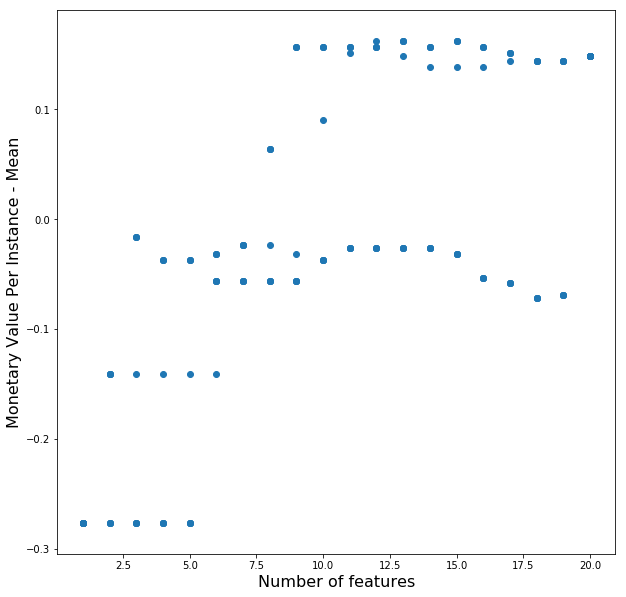

In [207]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(result_table[result_table["Model"] == "LogisticRegression"]["Feature Count"],
         result_table[result_table["Model"] == "LogisticRegression"]["Monetary Value Per Instance - Mean"])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [204]:
best_model = result_table_aggregated.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table_aggregated.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Features"]

print(best_model)
print(best_model_features)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
['trustLevel' 'lineItemVoids' 'scansWithoutRegistration'
 'scannedLineItemsPerSecond' 'valuePerSecond' 'scannedLineItems'
 'scansWithoutRegistrationPerScannedLineItem']


In [208]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm)

True negative:  1775
False positive:  0
False negative:  0
True positive:  104
520 for 1879 instances in the test set
0.2767429483767962 per instance in the test set
